# ParkRun Analysis
## Data relating to 5km ParkRun at MileEnd (22 and 29-Sep 2018)

I participated in a 5km Park Run (at MileEnd in London) and I did a comparative analysis of my first run vs the previous week.  The data were available on a website, which I extracted to from the URL to CSV using an online converter	http://www.convertcsv.com/html-table-to-csv.htm
I then imported this data into a PostgreSQL table, before reading into this Jupyter Notebook.

###### The analysis questions I set out to explore are:

(I) I wanted to get more familiar with PostgreSQL, as well as learning more about data cleaning and plotting.

(II) I based my analysis on comparing the datasets from the latest week (run 347, on 29 September) vs the prior week (run 346, on 22 September).  Then to make scatter plots to see if there was any relationship between a runner's age, and time to run the 5km course.  And finally to take a look at the r-squared values, to see if there was any major difference week-on-week. 



#### Import Libraries

In [44]:
import psycopg2 as pg  #for this I first needed to run !pip install psycopg2
import pandas.io.sql as psql
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

#### Connect to PostgreSQL data

In [45]:
conn = pg.connect(database="emma",user="postgres")
df = psql.read_sql('SELECT  run_nr, run_date, pos, parkrunner, run_time_raw, run_time,age_cat, gender, gender_pos, club, total_runs FROM projects.inp_002_03_parkrun ORDER BY run_nr, run_time', conn)
df.head()

,run_nr,run_date,pos,parkrunner,run_time_raw,run_time,age_cat,gender,gender_pos,club,total_runs
0,346,22/09/2018,136,Unknown,None,00:00:00,None,None,None,None,None
1,346,22/09/2018,295,Unknown,None,00:00:00,None,None,None,None,None
2,346,22/09/2018,278,Unknown,None,00:00:00,None,None,None,None,None
3,346,22/09/2018,277,Unknown,None,00:00:00,None,None,None,None,None
4,346,22/09/2018,274,Unknown,None,00:00:00,None,None,None,None,None


###### NOTE on run_time:
I encountered some issues initially in the formatting of the run time as it was exported to csv - times below 24 minutes were displaying in a different format than above. You can see the issue in the run_time_raw column- example below. It seems to be a standard CSV/Excel issue, and I worked around it in excel by dividing the time by 60 and reformatting as hh:mm:ss - and adding that as a new run_time column. 

In [46]:
df3 = df[['parkrunner', 'run_time_raw', 'run_time']]
df3.iloc[148:153, :]

,parkrunner,run_time_raw,run_time
148,Maria LONGVA,23:56,00:23:56
149,Matt CHOAT,23:57,00:23:57
150,Alejandro SALAS-SIERRA,23:59,00:23:59
151,Jo THOMPSON,24:00:00,00:24:00
152,James ROBERTSON,24:01:00,00:24:01


#### Clean Null Values from the dataset

In [47]:
print("# Null Rows",df['age_cat'].isna().sum()) #checking how many nulls in the column
print("\nOut of # Rows in total dataframe: ",len(df))

# Null Rows 95

Out of # Rows in total dataframe:  655


In [48]:
df = df[pd.notnull(df['age_cat'])]   #redefines the dataframe as only cases where age_cat is not 'null'
print("# Rows in cleaned dataframe: ",len(df),"\n")
pd.set_option('expand_frame_repr', False)  # Avoid text wrapping for Print
print(df.iloc[:5, 3:7])  # selecting 5 rows, and a subset of the columns to check the output is ok

# Rows in cleaned dataframe:  560 

              parkrunner run_time_raw  run_time  age_cat
42  Adam Alexander YOUNG        16:34  00:16:34  VM35-39
43         Sam MACNAMARA        17:00  00:17:00  SM30-34
44            Dave FINCH        17:07  00:17:07  VM45-49
45            Ben MOORES        17:32  00:17:32  SM30-34
46          Neil KIRKHAM        17:42  00:17:42  SM30-34


In [49]:
club_yn = np.where(df['club'].isna(),'N','Y')  #replaces long club name with a simpler yes no indicator of any club membership
df['club_yn']=club_yn
del df['club']
df.head()

,run_nr,run_date,pos,parkrunner,run_time_raw,run_time,age_cat,gender,gender_pos,total_runs,club_yn
42,346,22/09/2018,1,Adam Alexander YOUNG,16:34,00:16:34,VM35-39,M,1,123,Y
43,346,22/09/2018,2,Sam MACNAMARA,17:00,00:17:00,SM30-34,M,2,23,Y
44,346,22/09/2018,4,Dave FINCH,17:07,00:17:07,VM45-49,M,4,16,Y
45,346,22/09/2018,6,Ben MOORES,17:32,00:17:32,SM30-34,M,6,38,N
46,346,22/09/2018,7,Neil KIRKHAM,17:42,00:17:42,SM30-34,M,7,22,Y


#### Time formatting on run time, convert to minutes only

The run_time is a string (object) - it needs to be converted to a workable time format, before it can then be rounded to the nearest minute as integer.  We will later use this as the x-axis value on our scatter plots.

In [50]:
print("run_time__DTYPE WAS OBJECT:\n",df['run_time'].head(1))

s = pd.Series(pd.to_timedelta(df['run_time'], unit='s')) 
# this 'SERIES' is a really important step, otherwise it would not be possible to use eg. total_seconds function
print("\ns__DTYPE IS NOW TIMEDELTA!:\n",s.head(1))

#Source: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.total_seconds.html


run_time__DTYPE WAS OBJECT:
 42    00:16:34
Name: run_time, dtype: object

s__DTYPE IS NOW TIMEDELTA!:
 42   00:16:34
Name: run_time, dtype: timedelta64[ns]


In [51]:
df['run_time_min'] = round(s.dt.total_seconds()/60).astype(int)
# calc total seconds, divide by 60 for minutes, then round and show as integer - in a new column
df.head()

,run_nr,run_date,pos,parkrunner,run_time_raw,run_time,age_cat,gender,gender_pos,total_runs,club_yn,run_time_min
42,346,22/09/2018,1,Adam Alexander YOUNG,16:34,00:16:34,VM35-39,M,1,123,Y,17
43,346,22/09/2018,2,Sam MACNAMARA,17:00,00:17:00,SM30-34,M,2,23,Y,17
44,346,22/09/2018,4,Dave FINCH,17:07,00:17:07,VM45-49,M,4,16,Y,17
45,346,22/09/2018,6,Ben MOORES,17:32,00:17:32,SM30-34,M,6,38,N,18
46,346,22/09/2018,7,Neil KIRKHAM,17:42,00:17:42,SM30-34,M,7,22,Y,18


#### Do some exploration of the dataset

In [52]:
#Standard descriptive statistics - I chose to highlight only one column of interest = the run_time_min.
# I will compare across the two weeks
df.groupby(['run_nr']).run_time_min.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
run_nr,,,,,,,,
346,274.0,26.48,6.19,17.0,22.0,26.0,30.0,59.0
347,286.0,26.27,5.49,17.0,22.0,25.5,28.0,44.0


#### Extract numerical age information from age category string

I wish to use numerical age information for the y-axis of the scatterplots. Currently age_cat is displayed as a string with the age range at the end.  I need to extract the minumum and maximum age from each category, and derive one value (the mid) as the closest approximation I can get to the true age of each runner.

In [53]:
#start by listing out all the age_cat unique values
df.age_cat.unique()

array(['VM35-39', 'SM30-34', 'VM45-49', 'SM20-24', 'VM40-44', 'SM25-29',
       'VW35-39', 'SW20-24', 'VM50-54', 'JW15-17', 'SW25-29', 'JM11-14',
       'SW30-34', 'VM55-59', 'VW55-59', 'VW50-54', 'VW40-44', 'JW10',
       'VM65-69', 'VW45-49', 'VW60-64', 'VM60-64', 'JW11-14', 'VW65-69',
       'SM18-19', 'JM10', 'SW18-19'], dtype=object)

In [63]:
# Two of the categories JM10 and JW10 are formatted differently.
# I assume these are children up to 10 years, and re-format accordingly.
df.loc[df['age_cat'].str.endswith('10'),'age_cat'] = "JX01-10"   # replace with JX01-10 to match the general str length/format

In [69]:
# using a slice function, to extract the numerical portions of the string - the min and max of the age range
age_cat_min = df['age_cat'].str.slice(start=2, stop=4).astype(int)
age_cat_max = df['age_cat'].str.slice(start=5, stop=7).astype(int)
print("age_cat_min: \n",age_cat_min.head(2),"\n")
print("age_cat_max: \n",age_cat_max.head(2))

age_cat_min: 
 42    35
43    30
Name: age_cat, dtype: int32 

age_cat_max: 
 42    39
43    34
Name: age_cat, dtype: int32


In [56]:
# Here we get the average of the min and max ages within the category, and add it as a new column
df['age_cat_mid'] = ((age_cat_min + age_cat_max)/2).astype(int)
df.head(3)

,run_nr,run_date,pos,parkrunner,run_time_raw,run_time,age_cat,gender,gender_pos,total_runs,club_yn,run_time_min,age_cat_mid
42,346,22/09/2018,1,Adam Alexander YOUNG,16:34,00:16:34,VM35-39,M,1,123,Y,17,37
43,346,22/09/2018,2,Sam MACNAMARA,17:00,00:17:00,SM30-34,M,2,23,Y,17,32
44,346,22/09/2018,4,Dave FINCH,17:07,00:17:07,VM45-49,M,4,16,Y,17,47


#### Creating the visualisations_ Run nr 346 vs 347

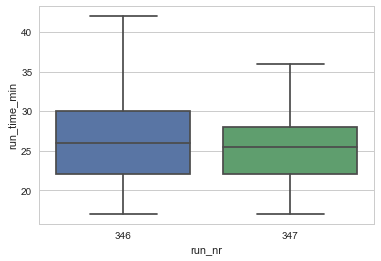

In [57]:
# I wanted to try out Seaborn, and improve on my last by plotting two boxplots side by side using the same axis & scale
sns.set(style="whitegrid")
ax = sns.boxplot(x="run_nr", y="run_time_min", data=df, showfliers=False)

(0, 75)

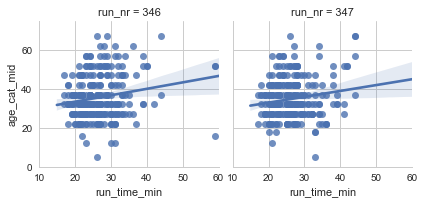

In [58]:
# Using seaborn to display regplots side by side
g = sns.FacetGrid(df, col="run_nr") 
g.map(sns.regplot, "run_time_min", "age_cat_mid") 
plt.xlim(10, 60) 
plt.ylim(0, 75)

#Source https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6

In [59]:
# Creating a sub dataframe per run number 
sdf347 = df.loc[df['run_nr'] == '347']
sdf346 = df.loc[df['run_nr'] == '346']

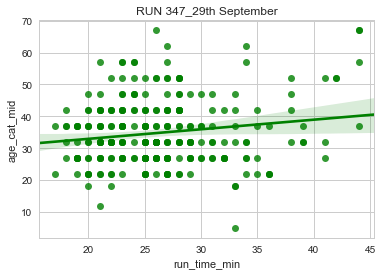

In [60]:
# A larger visualisation just for run number 347
ax = sns.regplot(x="run_time_min", y="age_cat_mid", data=sdf347, color='g')
ax.title.set_text('RUN 347_29th September')

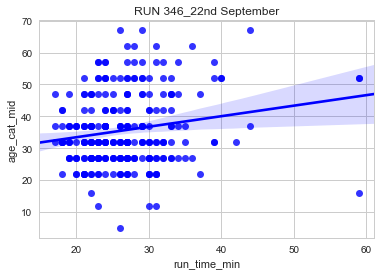

In [61]:
# A larger visualisation just for run number 346
ax = sns.regplot(x="run_time_min", y="age_cat_mid", data=sdf346, color='b')
ax.title.set_text('RUN 346_22nd September')

In [62]:
# I wanted to see the equation of the best fit line, and r-squared 
# my online searches indicated that it's not possible in Seaborn, so I used scipy instead

from scipy import stats
x347 = sdf347['run_time_min']
y347= sdf347['age_cat_mid']
x346 = sdf346['run_time_min']
y346= sdf346['age_cat_mid']


slope, intercept, r_value, p_value, std_err = stats.linregress(x347,y347)
print ("STATS FOR 347")
print ("r-squared:", (r_value**2).round(3))
print ("intercept:", intercept.round(3))
print ("slope:",slope.round(3))

slope, intercept, r_value, p_value, std_err = stats.linregress(x346,y346)
print ("\nSTATS FOR 346")
print ("r-squared:", (r_value**2).round(3))
print ("intercept:", intercept.round(3))
print ("slope:",slope.round(3))

# note: equation of line is  Y = intercept + slope X

STATS FOR 347
r-squared: 0.026
intercept: 26.929
slope: 0.3

STATS FOR 346
r-squared: 0.034
intercept: 26.846
slope: 0.33


## Conclusions from the Analysis
My main learning is that my result from my first parkrun was within the upper quartile - aka among the slower runners.  It can motivate me to strive towards the median at least!
Looking at the numbers across the two weeks, the core statistics looked quite similar, eg. not much difference in the median from week to week- however it was impacted a bit by some outliers in nr 346, particularly 3 'stragglers' of nearly 60 minutes, which stretched out the upper limits, and gave a higher std deviation.
Looking at my attempt at analysing as a regression, the relationship between age and running speed - there doesn't appear to be a strong link.  The slope indication is around 0.3, and the r-squared (which should indicate how well the regression 'fits' the data) is also quite low - as can also be perceived by looking at the pattern of dots which are scattered far from the line.


### Learnings from the project

This was more challenging than I expected, which resulted in some good experience in circumventing data issues and technical challenges.
I looked at exporting data directly from web tables to csv, and gained experience in using PostgreSQL (I have previously only worked with Microsoft SQL Server). 
The issue relating to the time formatting was quite difficult, and I would need to be aware of the pitfalls of date & time related data, and try to have that formatted as cleanly at source as possible to avoid time-consuming data wrangling in Python.
I definitely gained experience in manipulating strings and converting data to the format I need.
And I feel I have progressed in my knowledge of plotting/visualisation by expanding my efforts to Seaborn - my impression is that I have just scratched the surface with plotting and there's a ton of possibilities to learn!